# Lab 02: Image processing

In this lab session, we will use the gesture classification task as an example to demonstrate how to process image data with deep learning networks. This lab session includes:
- Dataset preparation 
  - Downloading 
  - Analysis and visualization 
  - Data augmentation
- CNN model building
  - From scratch
  - Transfer learning
- Training process
  - Early Stopping
  - Understanding the learning curve
  - Layer freezing


## Setup

First, we import some libraries for image processing and utils, as well as TensorFlow. Note that the module `image_dataset_from_directory` is necessary for downloading our data set from Google.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set the seed value for experiment reproducibility.
seed = 32
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Gesture dataset

Download and extract the `zip` file containing the datasets with `tf.keras.utils.get_file`. 

*Tips: [Here](https://www.tensorflow.org/datasets/catalog/overview) are more datasets available, and you can have a try.*

In [2]:
# Download our dataset used for training
TRAIN_SET_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip'
path_to_zip = tf.keras.utils.get_file('rps.zip', origin=TRAIN_SET_URL, extract=True, cache_dir='/content')
train_dir = os.path.join(os.path.dirname(path_to_zip), "rps")

# As well as the validation dataset
VAL_SET_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip'
path_to_zip2 = tf.keras.utils.get_file('rps-test-set.zip', origin=VAL_SET_URL, extract=True, cache_dir='/content')
validation_dir = os.path.join(os.path.dirname(path_to_zip2), "rps-test-set")

Then we can generate tf.data.Dataset from image files in a directory.



In [3]:
BATCH_SIZE = 32
IMG_SIZE = (96, 96) # why? what is the original image size?

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


Lets display some images of our dataset, as well as the class names.

Class names: ['paper', 'rock', 'scissors']
Number of classes: 3


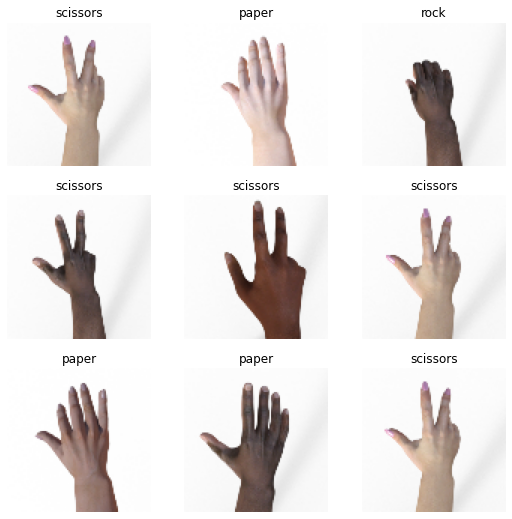

In [4]:
class_names = train_dataset.class_names
num_classes = len(train_dataset.class_names)
print("Class names:" , class_names)
print("Number of classes:", num_classes)

plt.figure(figsize=(9, 9))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Split test set and validation set
We are now taking a fifth of the validation dataset to use as our test set. The validation set will be used for observing if we got overfitting during training while the test set is for the final test after training:

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 10
Number of test batches: 2


### Configure the dataset for performance
Use buffered prefetching to load images from the disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## The Fist Model

### Create a CNN model
Let's define a simple Convolutional Neural Network Model(CNN) with several convolutional layers, followed by max pooling layers and a dense layer.
*Tips: information about parameters of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).*

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Create the cnn model 
IMG_SHAPE = IMG_SIZE + (3,)
model = Sequential([
  layers.InputLayer(input_shape=IMG_SHAPE),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

Compile the model before training it. We can define the used optimizer and the learning rate, the loss function, and which metrics to display while training: 

In [8]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

### Train the model

Now we should train the model for 10 epochs and see if it works:

In [10]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
79/79 [==============================] - 16s 134ms/step - loss: 9.7139 - accuracy: 0.7230 - val_loss: 0.3344 - val_accuracy: 0.8506
Epoch 2/10
79/79 [==============================] - 6s 70ms/step - loss: 0.0561 - accuracy: 0.9853 - val_loss: 1.0897 - val_accuracy: 0.7435
Epoch 3/10
79/79 [==============================] - 6s 69ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 1.2421 - val_accuracy: 0.7727
Epoch 4/10
79/79 [==============================] - 6s 69ms/step - loss: 2.3062e-04 - accuracy: 1.0000 - val_loss: 1.2555 - val_accuracy: 0.7500
Epoch 5/10
79/79 [==============================] - 6s 69ms/step - loss: 1.5132e-04 - accuracy: 1.0000 - val_loss: 1.1664 - val_accuracy: 0.7922
Epoch 6/10
79/79 [==============================] - 6s 71ms/step - loss: 1.0007e-04 - accuracy: 1.0000 - val_loss: 1.4274 - val_accuracy: 0.7597
Epoch 7/10
79/79 [==============================] - 6s 69ms/step - loss: 7.8010e-05 - accuracy: 1.0000 - val_loss: 1.3350 - val_accuracy: 0.

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss of our model:

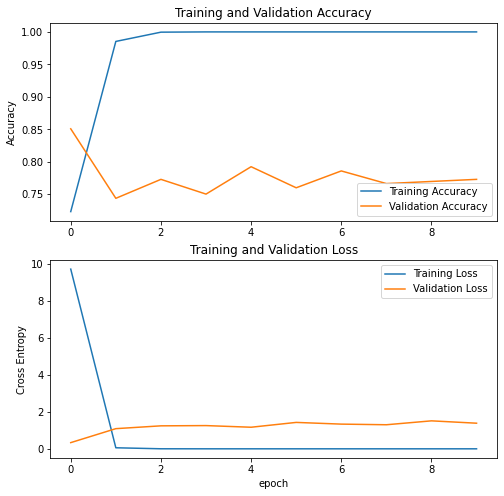

In [11]:
# Define a function so we can reuse it later
def draw_learning_curves(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

draw_learning_curves(history)

You can also verify the performance of the model on new data using test set:

In [12]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 1s 65ms/step - loss: 1.7208 - accuracy: 0.8125
Test accuracy : 0.8125


Your simple CNN model achieves 100% accuracy on the training set, it is working! **But**, on the validation set and test set, the model doesn't perform as good as a training set, why?

*The model fits too well into the training set and then becomes difficult for the model to generalize to new examples that were not in the training set. Your model recognizes specific images in your training set instead of general patterns, this is called overfitting.*


## Improvement
*Some strategies that could to overcome overfitting:*
- Increase the size of the training set
  - Add more data
  - Data augmentation
- Add dropout layers
- Early stop to avoid overtraining
- Take model architectures that generalize well

### Data augmentation
We want to add some random flips and rotations to the input images to get a more "varied" range of inputs, for that we define two preprocessing layers that the inputs pass in order:

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

You can add [other layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing), such as randomly zoom in/out.

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.predict`.

Let's repeatedly apply these layers to the same image and see the result.

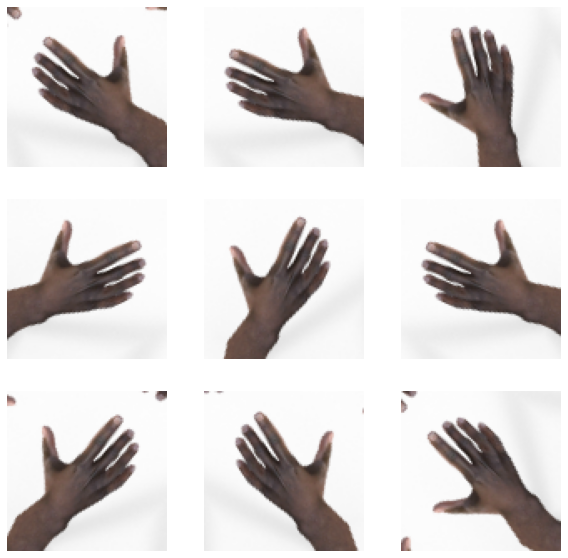

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(tf.dtypes.cast(augmented_image[0], tf.uint8))
    plt.axis('off')

### Embedding data augmentation and dropout to the CNN model

In [15]:
model = Sequential([
  layers.InputLayer(input_shape=IMG_SHAPE),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

# Compile the model
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)       

### Model training and learning curve

**Note**: This time we train the model with the early-stop strategy. Read more about `tf.keras.callbacks.EarlyStopping` [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

Epoch 1/100
79/79 [==============================] - 7s 73ms/step - loss: 23.1105 - accuracy: 0.5024 - val_loss: 0.9638 - val_accuracy: 0.4903
Epoch 2/100
79/79 [==============================] - 6s 70ms/step - loss: 0.5795 - accuracy: 0.7726 - val_loss: 0.9772 - val_accuracy: 0.6299
Epoch 3/100
79/79 [==============================] - 6s 69ms/step - loss: 0.3971 - accuracy: 0.8385 - val_loss: 0.6675 - val_accuracy: 0.7045
Epoch 4/100
79/79 [==============================] - 6s 74ms/step - loss: 0.3188 - accuracy: 0.8790 - val_loss: 0.4386 - val_accuracy: 0.7987
Epoch 5/100
79/79 [==============================] - 6s 69ms/step - loss: 0.3048 - accuracy: 0.8893 - val_loss: 0.4925 - val_accuracy: 0.7922
Epoch 6/100
79/79 [==============================] - 6s 70ms/step - loss: 0.1980 - accuracy: 0.9294 - val_loss: 0.3589 - val_accuracy: 0.8312
Epoch 7/100
79/79 [==============================] - 6s 69ms/step - loss: 0.1983 - accuracy: 0.9329 - val_loss: 0.3036 - val_accuracy: 0.8961
Epoch

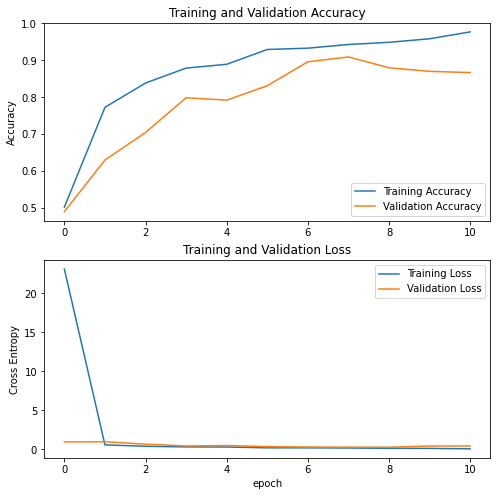

2/2 [==============================] - 1s 70ms/step - loss: 0.6302 - accuracy: 0.8125
Test accuracy : 0.8125


In [16]:
history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
                    validation_data=validation_dataset)

draw_learning_curves(history)

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

### Transfer learning

> This part is adapted from a [tutorial](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?hl=es) from TensorFlow. You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify gestures from our specific dataset.

#### Rescale pixel values

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To adapt to our images we use the preprocessing method included with the model.

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#### Create the base model from the pre-trained convnets



First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

Now, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.


In [18]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               alpha=0.35)

Let's see what it does to an example batch of images:

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(32, 3, 3, 1280)


The output information indicates that the feature extractor converts each 90x90x3 image into a 3x3x1280 block of features. 

#### Freeze the convolutional base
 It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting `layer.trainable = False`) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [20]:
base_model.trainable = False

Let's take a look at the base model architecture

In [21]:
base_model.summary()

Model: "mobilenetv2_0.35_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 16)   432         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 16)   0           ['bn_Conv1[0][0]']               
                                                                                

#### Add a classification head
To generate predictions from the block of features, average over the spatial 3x3 spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [23]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


####  Build and Compile the stacked model

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a BatchNormalization layer.

In [24]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_0.35_96 (Functi  (None, 3, 3, 1280)       410208    
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

The 0.4M parameters in MobileNet are frozen, but there are 3.8K trainable parameters in the Dense layer.  These are divided between two tf.Variable objects, the weights and biases.

#### Train the model
After training for 10 epochs, you should see ~94% accuracy on the validation set.

In [26]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 2s 27ms/step - loss: 1.4251 - accuracy: 0.2532
initial loss: 1.43
initial accuracy: 0.25


Epoch 1/10
79/79 [==============================] - 9s 73ms/step - loss: 0.9633 - accuracy: 0.5393 - val_loss: 0.7901 - val_accuracy: 0.6266
Epoch 2/10
79/79 [==============================] - 6s 70ms/step - loss: 0.5457 - accuracy: 0.8250 - val_loss: 0.6095 - val_accuracy: 0.7045
Epoch 3/10
79/79 [==============================] - 6s 69ms/step - loss: 0.3459 - accuracy: 0.9270 - val_loss: 0.4799 - val_accuracy: 0.8052
Epoch 4/10
79/79 [==============================] - 6s 70ms/step - loss: 0.2527 - accuracy: 0.9552 - val_loss: 0.4134 - val_accuracy: 0.8344
Epoch 5/10
79/79 [==============================] - 6s 70ms/step - loss: 0.1938 - accuracy: 0.9667 - val_loss: 0.3711 - val_accuracy: 0.8506
Epoch 6/10
79/79 [==============================] - 6s 70ms/step - loss: 0.1493 - accuracy: 0.9845 - val_loss: 0.3246 - val_accuracy: 0.8701
Epoch 7/10
79/79 [==============================] - 6s 69ms/step - loss: 0.1221 - accuracy: 0.9897 - val_loss: 0.3042 - val_accuracy: 0.8864
Epoch 8/10
79

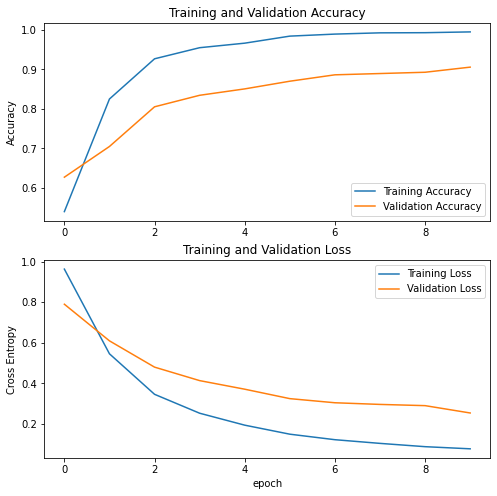

In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

draw_learning_curves(history)

#### Fine tuning
Now we also try to train some layers in the base model to improve the model's performance.

Let's take a look to see how many layers are in the base model

In [28]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


Ok, let fine tuning the weights in the 54 layers:

In [29]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [30]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_0.35_96 (Functi  (None, 3, 3, 1280)       410208    
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

Continue training the model


In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
79/79 [==============================] - 11s 84ms/step - loss: 0.0212 - accuracy: 0.9980 - val_loss: 0.2295 - val_accuracy: 0.9026
Epoch 11/20
79/79 [==============================] - 6s 75ms/step - loss: 0.0068 - accuracy: 0.9992 - val_loss: 0.2512 - val_accuracy: 0.8994
Epoch 12/20
79/79 [==============================] - 6s 76ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.2900 - val_accuracy: 0.8994
Epoch 13/20
79/79 [==============================] - 7s 77ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2211 - val_accuracy: 0.9156
Epoch 14/20
79/79 [==============================] - 7s 87ms/step - loss: 5.1083e-04 - accuracy: 1.0000 - val_loss: 0.1959 - val_accuracy: 0.9253
Epoch 15/20
79/79 [==============================] - 6s 75ms/step - loss: 2.8503e-04 - accuracy: 1.0000 - val_loss: 0.2693 - val_accuracy: 0.9026
Epoch 16/20
79/79 [==============================] - 6s 75ms/step - loss: 1.0376e-04 - accuracy: 1.0000 - val_loss: 0.3648 - val_accuracy: 

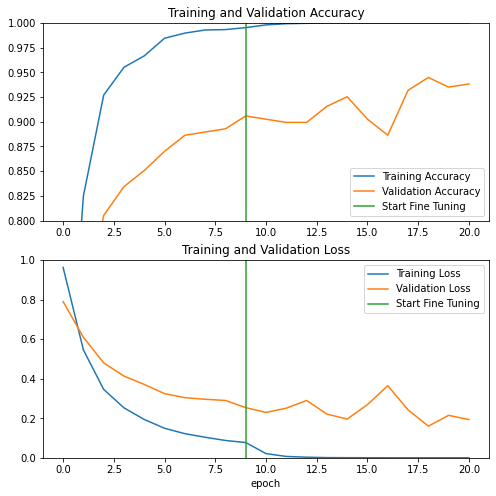

In [32]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

 ### Evaluation and prediction
 Finaly you can verify the performance of the model on new data using test set.

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 1s 73ms/step - loss: 0.2260 - accuracy: 0.9375
Test accuracy : 0.9375


 And now you are all set to use this model to predict the input gesture.

Predictions:
 [0 1 1 0 2 1 2 1 1 1 0 0 0 2 1 2 1 2 2 0 0 0 0 0 0 0 0 2 0 1 1 2]
Labels:
 [0 1 1 0 2 1 2 1 0 1 0 0 0 2 0 2 1 2 2 0 0 0 0 0 0 0 0 2 0 1 1 2]


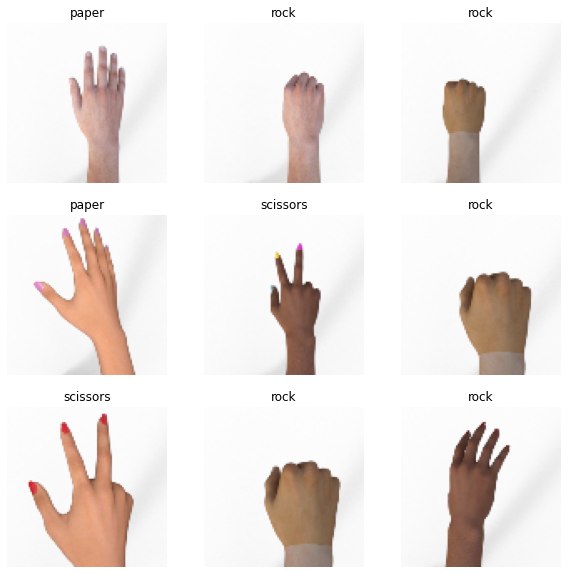

In [34]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

#Get predictions
predList = []
for pred in predictions:
  predList.append(np.argmax(pred))

predictions = np.asarray(predList)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

#Draw fist 10 gestures
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## What is the next?

1. Train a CNN on another dataset
2. Apply all strategies introduced in this notebook to train the CNN
3. Port your well-trained model and we will use them in the next session. 

In [35]:
# dataset loading and preparing, try more augmentation methods





# Creating your CNN model(either from scratch or transfer learning)





# Train the CNN model





# Test the trained CNN model and store it to the hard disk




model.save('model_rps.h5')